In [1]:
import importlib

import numpy as np
from matplotlib import pyplot as plt

# Our first optimal control problem using KKT conditions
Consider the [discretized moving car model](Lecture%201%20-%20black%20box%20solvers.ipynb) where we write the position $p$ and velocity $v$ in a single state vector $x = \begin{pmatrix} p \\ v \end{pmatrix}$ and the following optimal control problem with a quadratic cost

$$\begin{align}
& \min_{x_n, u_n} \frac{1}{2}(\sum_{n=0}^{N-1} x_n^T Q x_n + u_n^T R u_n + x_N Q x_N)\\
\textrm{subject to} \ \ \ \ & x_{n+1} = A x_n + B u_n\\
& x_0 = x_{init}
\end{align}$$

where $Q,R \geq0$ and $A = \begin{bmatrix}1 & \Delta t \\ 0 & 1 \end{bmatrix}$, $B=\begin{bmatrix}0\\ \Delta t \end{bmatrix}$

The problem can be rewritten in matrix form as
$$\begin{align}
& \min_{y} \frac{1}{2} y^T G y\\
\textrm{subject to} \ \ \ \ & C y = d
\end{align}$$

where $y^T = \begin{pmatrix}x_0 & u_0 & x_1 & u_1 & \cdots \end{pmatrix}$, 
$G = \begin{bmatrix} Q & 0 & 0 & 0 & \cdots \\ 0 & R & 0 & 0 & \cdots \\ 0 & 0 & Q & 0 & \cdots \\ 0 & 0 & 0 & R & \cdots \\ \vdots&\vdots &\vdots &\vdots  &\ddots \end{bmatrix}$,
$C = \begin{bmatrix} I & 0 & 0 & 0 & 0 & \cdots \\ A & B & -I & 0 & 0 & \cdots \\ 0 & 0 & A & B & -I &\cdots \\ \vdots&\vdots &\vdots &\vdots &\vdots  &\ddots \end{bmatrix}$ and $d^T = \begin{pmatrix}x_{init} & 0 & 0 &\cdots \end{pmatrix}$

## KKT conditions
The Lagrangian of the problem is $L(y,\lambda) = \frac{1}{2} y^T G y + \lambda^T (C y - d)$ and the KKT conditions for optimality are
$$ \begin{bmatrix} G & C^T \\ C & 0 \end{bmatrix} \begin{pmatrix} y \\ \lambda \end{pmatrix} = \begin{pmatrix} 0 \\ d \end{pmatrix}$$

So to find a solution to the problem (which is convex), we just need to solve the KKT linear equation. This is what we do below.


Text(0, 0.5, 'acceleration')

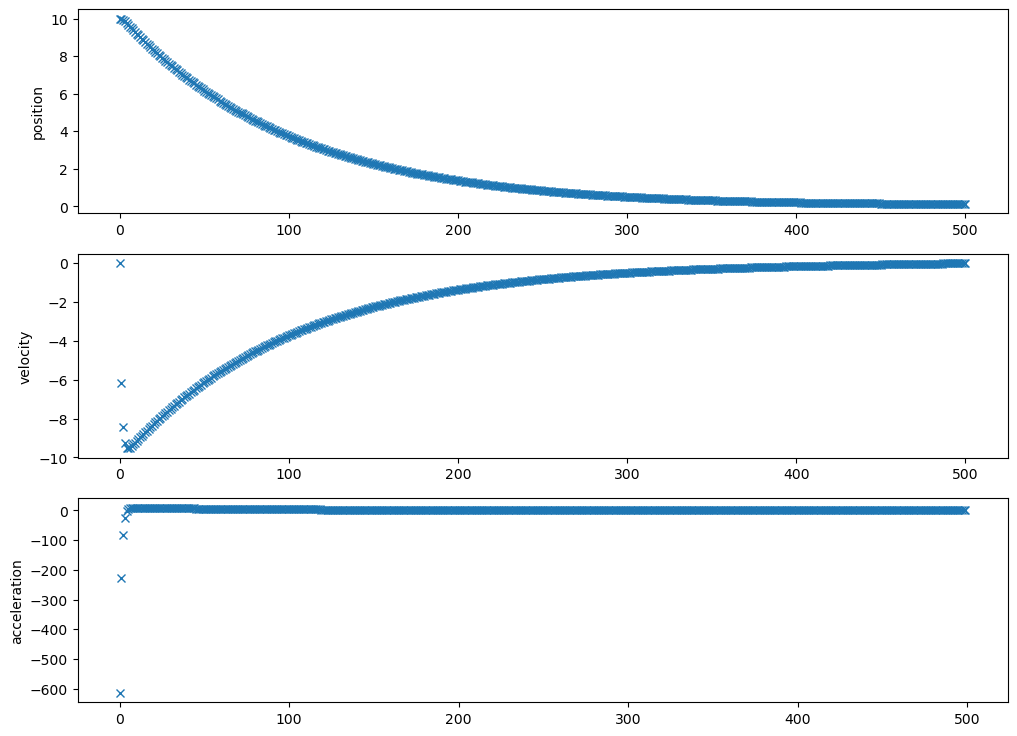

In [2]:
# we define a few constants
xdim = 2 # dimension of the state (p,v)
udim = 1 # dimension of the control (u)
N = 500 # number of steps
nvars = N*udim + (N+1)*xdim # total number of variables
dt = 0.01 #delta t

## We define the cost
Q = np.eye(xdim)
Q[0,0] = 100. # the position penalty
Q[1,1] = 100. # the velocity penalty
R = np.eye(udim) * 0.01


## we create G
def get_cost_matrix_G(Q, R):
    '''
    we are making this a function so we can reuse this later in the next cells when we play with costs
    '''
    G = np.zeros((nvars, nvars))
    for i in range(N):
        G[i*(xdim+udim):i*(xdim+udim)+xdim,i*(xdim+udim):i*(xdim+udim)+xdim] = Q
        G[i*(xdim+udim)+xdim:i*(xdim+udim)+xdim+udim, i*(xdim+udim)+xdim:i*(xdim+udim)+xdim+udim] = R
    G[N*(xdim+udim):N*(xdim+udim)+xdim,N*(xdim+udim):N*(xdim+udim)+xdim] = Q
    return G

G = get_cost_matrix_G(Q,R)

##### CREATE THE KKT SYSTEM #####
## create the linear equality constraint
C = np.zeros([xdim * (N+1), nvars])
d = np.zeros([xdim * (N+1)])

C[0:2, 0:2] = np.eye(xdim)
d[0] = 10. # initial position of the car

A = np.array([[1, dt],[0,1]])
B = np.array([[0], [dt]])

for i in range(N):
    ##u
    C[(i+1)*xdim:(i+2)*xdim, i*(xdim+udim)+xdim:i*(xdim+udim)+xdim+1] = B
    ##x n+1
    C[(i+1)*xdim:(i+2)*xdim, (i+1)*(xdim+udim):(i+1)*(xdim+udim)+xdim] = -np.eye(xdim)
    ## xn
    C[(i+1)*xdim:(i+2)*xdim, i*(xdim+udim):(i)*(xdim+udim)+xdim] = A

## create the KKT matrix
nconstraints = C.shape[0]
KKT = np.zeros((nvars+nconstraints, nvars+nconstraints))

KKT[0:nvars, 0:nvars] = G
KKT[nvars:, 0:nvars] = C
KKT[0:nvars, nvars:] = C.T

f = np.zeros((nvars+nconstraints,1))
f[nvars:,0] = d

##### SOLVE THE KKT SYSTEM #####
x = np.linalg.solve(KKT, f)

### read the answers back to p,v,u
car_position = x[0:nvars:3]
car_velocity = x[1:nvars:3]
control = x[2:nvars:3]

plt.figure(figsize=[12,9])
plt.subplot(3,1,1)
plt.ylabel('position')
plt.plot(car_position, 'x')
plt.subplot(3,1,2)
plt.ylabel('velocity')
plt.plot(car_velocity, 'x')
plt.subplot(3,1,3)
plt.plot(control, 'x')
plt.ylabel('acceleration')

# Tracking a desired trajectory
We can also track a desired trajectory $\bar{x}_n$, for example using the cost
$$\frac{1}{2}(\sum_{n=0}^{N-1} (x_n - \bar{x}_n)^T Q (x_n - \bar{x}_n) + u_n^T R u_n + (x_N - \bar{x}_N) Q (x_N - \bar{x}_N))$$
which penalizes deviation of the state from the desired state. This is equivalent to minimizing this cost (expanding and then ignoring constant terms, i.e. terms that do not depend on $x_n$)
$$\sum_{n=0}^{N-1} \left( \frac{1}{2}x_n^T Q x_n + \frac{1}{2}u_n^T R u_n - \bar{x}_n^T Q x_n \right) + \frac{1}{2}x_N Q x_N + \bar{x}_N Q x_N$$


We now have the optimal control problem 
$$\begin{align}
& \min_{x_n, u_n} \sum_{n=0}^{N-1} \left( \frac{1}{2}x_n^T Q x_n + \frac{1}{2}u_n^T R u_n - \bar{x}_n^T Q x_n \right) + \frac{1}{2}x_N Q x_N + \bar{x}_N Q x_N\\
\textrm{subject to} \ \ \ \ & x_{n+1} = \begin{bmatrix}1 & \Delta t \\ 0 & 1 \end{bmatrix}x_n + \begin{bmatrix}0\\ \Delta t \end{bmatrix} u_n\\
& x_0 = x_{init}
\end{align}$$

The problem can be rewritten in matrix form as
$$\begin{align}
& \min_{y} \frac{1}{2} y^T G y + g^T y\\
\textrm{subject to} \ \ \ \ & M y = p
\end{align}$$

where the only difference with before is that now we have $g^T = \begin{pmatrix} -\bar{x}_0^T Q & 0 &  -\bar{x}_1^T Q & 0 & -\bar{x}_2^T Q & \cdots \end{pmatrix}$

## KKT conditions
The Lagrangian of the problem is $L(y,\lambda) = \frac{1}{2} y^T G y + g^T y + \lambda^T (M y - p)$ and the KKT conditions for optimality are
$$ \begin{bmatrix} G & M^T \\ M & 0 \end{bmatrix} \begin{pmatrix} y \\ \lambda \end{pmatrix} = \begin{pmatrix} -g \\ p \end{pmatrix}$$

So a modest modication to the code above allows to now track trajectories. Below we solve the problem tracking a sine wave (the velocity needs to be the derivative of the position) $\bar{x}_n = \begin{pmatrix}\sin(2 \pi i \Delta t) \\ 2\pi \cos(2 \pi i \Delta t)  \end{pmatrix}$


Text(0, 0.5, 'acceleration')

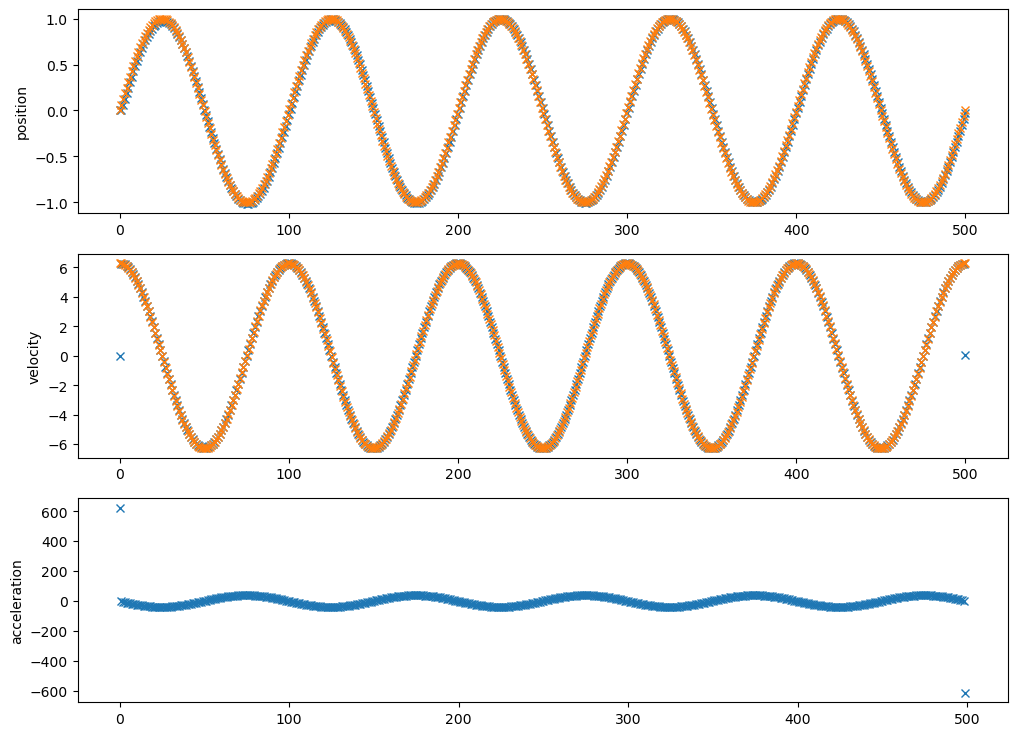

In [3]:
## in the following we assume we still have the variables defined above - we only modify what we need

## We re-define the cost (we want to tune this)
Q = np.eye(xdim)
Q[0,0] = 1000. # the position penalty
Q[1,1] = 1000. # the velocity penalty
R = np.eye(udim) * 0.001

G = get_cost_matrix_G(Q,R)
KKT[0:nvars, 0:nvars] = G

### MODIFICATION we need to create g
g = np.zeros((nvars))
for i in range(N):
    g[i*(xdim+udim):i*(xdim+udim)+xdim] = -np.array([[np.sin(2*np.pi*i*dt),2*np.pi*np.cos(2*np.pi*i*dt)]]) @ Q

d[0] = 0. # initial position of the car

### MODIFICATION 3 we add g to the KKT linear equation
f[0:nvars,0] = -g
f[nvars:,0] = d

##### SOLVE THE KKT SYSTEM #####
x = np.linalg.solve(KKT, f)


### read the answers back to p,v,u
car_position = x[0:nvars:3]
car_velocity = x[1:nvars:3]
control = x[2:nvars:3]

t = np.linspace(0,N,N)
plt.figure(figsize=[12,9])
plt.subplot(3,1,1)
plt.ylabel('position')
plt.plot(car_position, 'x')
plt.plot(t, np.sin(2*np.pi*t*dt),'x')
plt.subplot(3,1,2)
plt.ylabel('velocity')
plt.plot(car_velocity, 'x')
plt.plot(t, 2*np.pi*np.cos(2*np.pi*t*dt),'x')
plt.subplot(3,1,3)
plt.plot(control, 'x')
plt.ylabel('acceleration')

## Adding inequality constraints

Now we can also add limits on the controls or states and solve a QP

$$\begin{align}
& \min_{x_n, u_n} \sum_{n=0}^{N-1} \left( \frac{1}{2}x_n^T Q x_n + \frac{1}{2}u_n^T R u_n - \bar{x}_n^T Q x_n \right) + \frac{1}{2}x_N Q x_N + \bar{x}_N Q x_N\\
\textrm{subject to} \ \ \ \ & x_{n+1} = \begin{bmatrix}1 & \Delta t \\ 0 & 1 \end{bmatrix}x_n + \begin{bmatrix}0\\ \Delta t \end{bmatrix} u_n\\
& u_{min} \leq u_n \leq u_{max} \\
& x_{min} \leq x_n \leq x_{max} \\
& x_0 = x_{init}
\end{align}$$

Text(0, 0.5, 'acceleration')

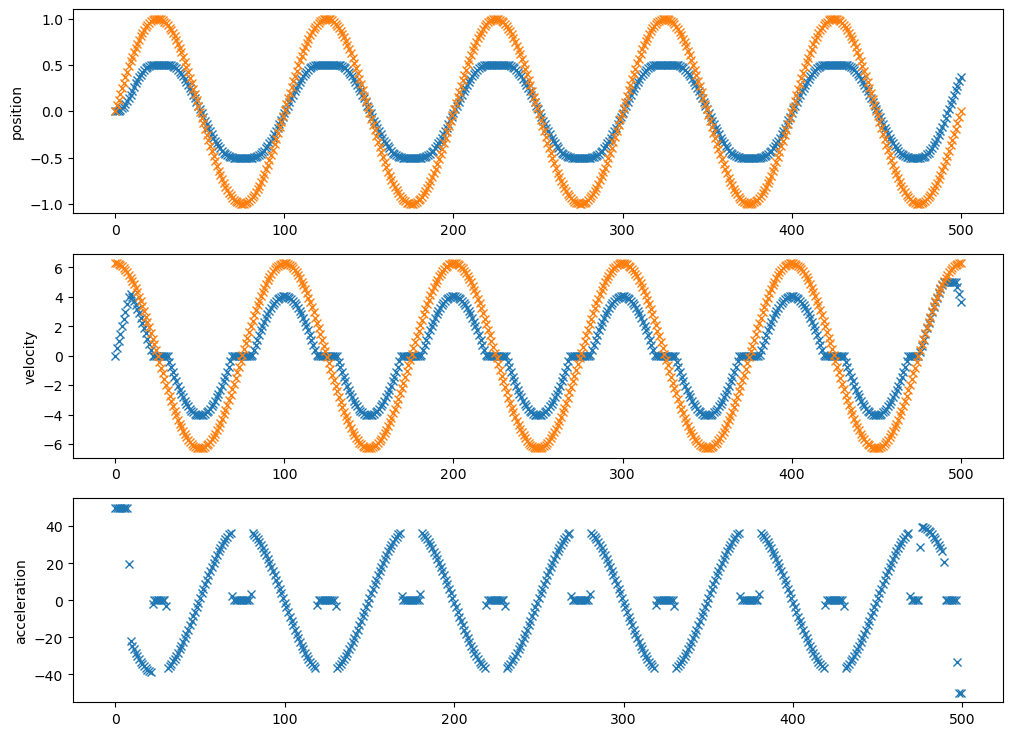

In [4]:
# we use the qpsolvers library which containts a unified interface to many QP solvers
# https://pypi.org/project/qpsolvers/
from qpsolvers import solve_qp

## again we do not need to recreate the matrices we created before
## We re-define the cost (we want to tune this)
Q = np.eye(xdim)
Q[0,0] = 1000. # the position penalty
Q[1,1] = 1000. # the velocity penalty
R = np.eye(udim) * 0.001

G = get_cost_matrix_G(Q,R)
KKT[0:nvars, 0:nvars] = G

d[0] = 0. # initial position of the car

# creating bounds on the control and states
H = np.zeros((2*N*(udim +xdim)+2*xdim, nvars))
h = np.zeros((2*N*(udim + xdim)+2*xdim))

## feel free to play with these bounds
u_max = np.array([50.])
x_max = np.array([0.5,5.])

for i in range(N+1):
    if i < N:
        H[(udim+xdim)*i+xdim:(udim+xdim)*i+xdim+udim,i*(xdim+udim)+xdim:i*(xdim+udim)+xdim+1] = np.eye(udim)
        h[(udim+xdim)*i+xdim:(udim+xdim)*i+xdim+udim] = u_max
        H[(udim+xdim)*i+xdim+N*(udim+xdim)+xdim:(udim+xdim)*i+udim+xdim+N*(udim+xdim)+xdim,i*(xdim+udim)+xdim:i*(xdim+udim)+xdim+1] = -np.eye(udim)
        h[(udim+xdim)*i+xdim+N*(udim+xdim)+xdim:(udim+xdim)*i+udim+xdim+N*(udim+xdim)+xdim] = u_max
        
    H[(udim+xdim)*i:(udim+xdim)*i+xdim,i*(xdim+udim):(i)*(xdim+udim)+xdim] = np.eye(xdim)
    h[(udim+xdim)*i:(udim+xdim)*i+xdim] = x_max
    H[(udim+xdim)*i+N*(udim+xdim)+xdim:(udim+xdim)*i+xdim+N*(udim+xdim)+xdim,i*(xdim+udim):(i)*(xdim+udim)+xdim] = -np.eye(xdim)
    h[(udim+xdim)*i+N*(udim+xdim)+xdim:(udim+xdim)*i+xdim+N*(udim+xdim)+xdim] = x_max

# g = np.zeros((nvars))

# ## creating bounds on the state
# H = np.zeros((2*N*xdim, nvars))
# h = np.zeros((2*N*xdim))
# x_max = np.array([0.5,100.])
# for i in range(N):
#     H[xdim*i:xdim*i+xdim,i*(xdim+udim):(i)*(xdim+udim)+xdim] = np.eye(xdim)
#     h[xdim*i:xdim*i+xdim] = x_max
#     H[xdim*i+N*xdim:xdim*i+xdim+N*xdim,i*(xdim+udim):(i)*(xdim+udim)+xdim] = -np.eye(xdim)
#     h[xdim*i+N*xdim:xdim*i+xdim+N*xdim] = x_max

x = solve_qp(G, g, H, h, C, d, solver="cvxopt")

### read the answers back to p,v,u
car_position = x[0:nvars:3]
car_velocity = x[1:nvars:3]
control = x[2:nvars:3]

t = np.linspace(0,N,N)
plt.figure(figsize=[12,9])
plt.subplot(3,1,1)
plt.ylabel('position')
plt.plot(car_position, 'x')
plt.plot(t, np.sin(2*np.pi*t*dt),'x')
plt.subplot(3,1,2)
plt.ylabel('velocity')
plt.plot(car_velocity, 'x')
plt.plot(t, 2*np.pi*np.cos(2*np.pi*t*dt),'x')
plt.subplot(3,1,3)
plt.plot(control, 'x')
plt.ylabel('acceleration')